<a href="https://colab.research.google.com/github/jinjinamanda/Projets-data-analyst/blob/main/Identifier_les_pays_potentiellement_int%C3%A9ressants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
import pandas as pd
import numpy as np

import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

dfDisponibiliteAlimentaire = pd.read_csv('/content/DisponibiliteAlimentaire_2017.csv', keep_default_na=False)
dfPopulation = pd.read_csv('/content/Population_2000_2018.csv', keep_default_na=False)
dfPoliticalStability = pd.read_csv('/content/PoliticalStability - PoliticalStability.csv', keep_default_na=False)
import warnings
warnings. simplefilter(action='ignore', category=Warning)


In [125]:
dfDisponibiliteAlimentaire.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [126]:
dfPoliticalStability.head()

,Country,Year,Political_Stability,Granularity
0,Afghanistan,2000,-2.44,Total
1,Afghanistan,2002,-2.04,Total
2,Afghanistan,2003,-2.20,Total
3,Afghanistan,2004,-2.30,Total
4,Afghanistan,2005,-2.07,Total


In [127]:
# Filtrer les données pour l'année 2017
political_stability_2017 = dfPoliticalStability[dfPoliticalStability['Year'] == 2017]
political_stability_2017.head()

,Country,Year,Political_Stability,Granularity
16,Afghanistan,2017,-2.80,Total
34,Albania,2017,0.38,Total
52,Algeria,2017,-0.92,Total
67,American Samoa,2017,1.22,Total
85,Andorra,2017,1.42,Total


In [128]:
# Renaming the 'Country' column to 'Zone'
political_stability_2017 = political_stability_2017.rename(columns={'Country': 'Zone'})

# Display the first few rows to confirm the change
political_stability_2017.head()


,Zone,Year,Political_Stability,Granularity
16,Afghanistan,2017,-2.80,Total
34,Albania,2017,0.38,Total
52,Algeria,2017,-0.92,Total
67,American Samoa,2017,1.22,Total
85,Andorra,2017,1.42,Total


In [129]:
# Nettoyage des Données: vérification des valeurs manquantes et des types de données

population_missing_values = dfPopulation.isnull().sum()
DisponibiliteAlimentaire_missing_values = dfDisponibiliteAlimentaire.isnull().sum()

population_data_types = dfPopulation.dtypes
DisponibiliteAlimentaire_data_types = dfDisponibiliteAlimentaire.dtypes

# Calcul des statistiques descriptives pour les variables numériques
population_describ = dfPopulation.describe()
disponibiliteAlimentaire_describ = dfDisponibiliteAlimentaire.describe()

population_missing_values, DisponibiliteAlimentaire_missing_values, population_data_types, DisponibiliteAlimentaire_data_types, population_describ, disponibiliteAlimentaire_describ



(Code Domaine              0
 Domaine                   0
 Code zone                 0
 Zone                      0
 Code Élément              0
 Élément                   0
 Code Produit              0
 Produit                   0
 Code année                0
 Année                     0
 Unité                     0
 Valeur                    0
 Symbole                   0
 Description du Symbole    0
 Note                      0
 dtype: int64,
 Code Domaine              0
 Domaine                   0
 Code zone                 0
 Zone                      0
 Code Élément              0
 Élément                   0
 Code Produit              0
 Produit                   0
 Code année                0
 Année                     0
 Unité                     0
 Valeur                    0
 Symbole                   0
 Description du Symbole    0
 dtype: int64,
 Code Domaine               object
 Domaine                    object
 Code zone                   int64
 Zone                   

In [130]:
dfImportationProduction = dfDisponibiliteAlimentaire.loc[dfDisponibiliteAlimentaire["Élément"].isin(["Importations - Quantité", "Production"])]
dfImportationProduction.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
14,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2805,Riz et produits,2017,2017,Milliers de tonnes,338.0,S,Données standardisées
15,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2805,Riz et produits,2017,2017,Milliers de tonnes,415.0,S,Données standardisées
27,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2513,Orge et produits,2017,2017,Milliers de tonnes,95.0,S,Données standardisées


In [131]:
dfImportationProductionViandevolaille = dfImportationProduction.loc[dfImportationProduction["Produit"] == "Viande de Volailles"]
dfImportationProductionViandevolaille.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
651,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,28.0,S,Données standardisées
652,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,29.0,S,Données standardisées
1704,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,1667.0,S,Données standardisées
1705,FBS,Nouveaux Bilans Alimentaire,202,Afrique du Sud,5611,Importations - Quantité,2734,Viande de Volailles,2017,2017,Milliers de tonnes,514.0,S,Données standardisées
2713,FBS,Nouveaux Bilans Alimentaire,3,Albanie,5511,Production,2734,Viande de Volailles,2017,2017,Milliers de tonnes,13.0,S,Données standardisées


In [132]:
dfpivot_tablevolaille = dfImportationProductionViandevolaille.pivot_table(values="Valeur", index=["Zone","Produit"], columns="Élément")
dfpivot_tablevolaille.head()

,Élément,Importations - Quantité,Production
Zone,Produit,,
Afghanistan,Viande de Volailles,29.0,28.0
Afrique du Sud,Viande de Volailles,514.0,1667.0
Albanie,Viande de Volailles,38.0,13.0
Algérie,Viande de Volailles,2.0,275.0
Allemagne,Viande de Volailles,842.0,1514.0


In [133]:
dfPopulation.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,


In [134]:
dfPopulationsort= dfPopulation.sort_values(["Zone","Année"], ascending=True)
dfPopulationsort.head(10)

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,
5,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2005,2005,1000 personnes,25654.277,X,Sources internationales sûres,
6,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2006,2006,1000 personnes,26433.049,X,Sources internationales sûres,
7,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2007,2007,1000 personnes,27100.536,X,Sources internationales sûres,
8,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2008,2008,1000 personnes,27722.276,X,Sources internationales sûres,
9,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2009,2009,1000 personnes,28394.813,X,Sources internationales sûres,


In [135]:
dfPopulationsort["Évolution population"] = dfPopulationsort["Valeur"].diff(1)/dfPopulationsort["Valeur"].shift(1)

dfPopulationsort["Valeur"] = dfPopulationsort["Valeur"].replace(to_replace=2000,value=np.nan)

dfPopulation20012017 = dfPopulationsort.loc[(dfPopulationsort["Année"] >= 2001) & (dfPopulationsort["Année"] <= 2017)]

dfmoyenne_evolution_population = dfPopulation20012017["Évolution population"].mean()

print(dfmoyenne_evolution_population)

0.05451865989988544


In [136]:
dfPopulation2017 = dfPopulation20012017.loc[(dfPopulation20012017["Année"] == 2017)]
dfPopulation2017.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note,Évolution population
17,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,36296.113,X,Sources internationales sûres,,0.025806
36,OA,Séries temporelles annuelles,202,Afrique du Sud,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,57009.756,X,Sources internationales sûres,,0.014270
55,OA,Séries temporelles annuelles,3,Albanie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,2884.169,X,Sources internationales sûres,,-0.000786
74,OA,Séries temporelles annuelles,4,Algérie,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,41389.189,X,Sources internationales sûres,,0.020660
93,OA,Séries temporelles annuelles,79,Allemagne,511,Population totale,3010,Population-Estimations,2017,2017,1000 personnes,82658.409,X,Sources internationales sûres,,0.005653


In [137]:
dfmergedviandevolaille = pd.merge(dfpivot_tablevolaille,dfPopulation2017[['Zone','Valeur','Évolution population']], on="Zone")
dfmergedviandevolaille.head()


,Zone,Importations - Quantité,Production,Valeur,Évolution population
0,Afghanistan,29.0,28.0,36296.113,0.025806
1,Afrique du Sud,514.0,1667.0,57009.756,0.014270
2,Albanie,38.0,13.0,2884.169,-0.000786
3,Algérie,2.0,275.0,41389.189,0.020660
4,Allemagne,842.0,1514.0,82658.409,0.005653


In [138]:
dfmerged= pd.merge(political_stability_2017[['Zone','Political_Stability']], dfmergedviandevolaille[['Zone','Importations - Quantité', 'Production','Valeur','Évolution population']], on="Zone")
dfmerged.head()
# Renaming the 'Country' column to 'Zone'
dfmergedrename = dfmerged.rename(columns={'Zone': 'Pays', 'Valeur': "Population"})

In [139]:
dfmergedrename.head()

,Pays,Political_Stability,Importations - Quantité,Production,Population,Évolution population
0,Afghanistan,-2.80,29.0,28.0,36296.113,0.025806
1,Angola,-0.33,277.0,42.0,29816.766,0.033779
2,Bahamas,0.99,24.0,6.0,381.755,0.010121
3,Bangladesh,-1.26,0.0,249.0,159685.424,0.010813
4,Belize,0.04,0.0,20.0,375.769,0.020003


In [140]:
# Checking for missing values and data types in both datasets
missingdata = dfmergedrename.isnull().sum()
print(missingdata)

Pays                       0
Political_Stability        0
Importations - Quantité    0
Production                 2
Population                 0
Évolution population       0
dtype: int64


In [141]:
# Data types
datatype = dfmergedrename.dtypes
print(datatype)

Pays                        object
Political_Stability        float64
Importations - Quantité    float64
Production                 float64
Population                 float64
Évolution population       float64
dtype: object


In [142]:
# Remplacement des valeurs manquantes par la valeur moyenne de la colonne 'Production'
mean_production = dfmergedrename['Production'].median()
dfmergedrename['Production'].fillna(mean_production, inplace=True)

# Vérification à nouveau des valeurs manquantes après remplacement
missing_data_updated = dfmergedrename.isnull().sum()
missing_data_updated, dfmergedrename.head()

(Pays                       0
 Political_Stability        0
 Importations - Quantité    0
 Production                 0
 Population                 0
 Évolution population       0
 dtype: int64,
           Pays  Political_Stability  Importations - Quantité  Production  \
 0  Afghanistan                -2.80                     29.0        28.0   
 1       Angola                -0.33                    277.0        42.0   
 2      Bahamas                 0.99                     24.0         6.0   
 3   Bangladesh                -1.26                      0.0       249.0   
 4       Belize                 0.04                      0.0        20.0   
 
    Population  Évolution population  
 0   36296.113              0.025806  
 1   29816.766              0.033779  
 2     381.755              0.010121  
 3  159685.424              0.010813  
 4     375.769              0.020003  )

In [143]:
from sklearn.preprocessing import RobustScaler

# Assurez-vous que la liste des colonnes numériques est à jour avec les nouveaux noms de colonnes
numeric_columns = ['Political_Stability', 'Importations - Quantité', 'Production', 'Population', 'Évolution population']

# Creating an instance of RobustScaler
scaler = RobustScaler()

# Applying the RobustScaler to the numeric columns
data_normalized = dfmergedrename.copy()
data_normalized[numeric_columns] = scaler.fit_transform(dfmergedrename[numeric_columns])

# Displaying the first few rows of the scaled dataframe
data_normalized.head()


,Pays,Political_Stability,Importations - Quantité,Production,Population,Évolution population
0,Afghanistan,-2.264463,0.217252,-0.114943,1.024390,0.545962
1,Angola,-0.223140,3.386581,-0.022989,0.773329,1.049750
2,Bahamas,0.867769,0.153355,-0.259442,-0.367214,-0.445027
3,Bangladesh,-0.991736,-0.153355,1.336617,5.805459,-0.401275
4,Belize,0.082645,-0.153355,-0.167488,-0.367446,0.179323


In [144]:
# Réessayer le calcul et l'affichage de la variance expliquée
try:
    # Calcul de la variance expliquée par chaque composante principale
    explained_variance = pca.explained_variance_ratio_

    # Création d'un DataFrame pour une meilleure visualisation
    explained_variance_df = pd.DataFrame({
        'PC': ['PC' + str(i + 1) for i in range(len(explained_variance))],
        'Variance Expliquée (%)': explained_variance * 100,
        'Variance Cumulée (%)': explained_variance.cumsum() * 100
    })
except Exception as e:
    error_message = str(e)

explained_variance_df if 'explained_variance_df' in locals() else error_message


,PC,Variance Expliquée (%),Variance Cumulée (%)
0,PC1,72.135210,72.135210
1,PC2,12.585972,84.721182
2,PC3,10.035164,94.756346
3,PC4,3.241926,97.998273
4,PC5,2.001727,100.000000


In [145]:
def find_outliers(dataframe, column):

    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)

# Applying the function to each numeric column and storing the results
outliers = pd.DataFrame({col: find_outliers(data_normalized, col) for col in data_normalized.select_dtypes(include='number').columns})

# Displaying rows that contain outliers in any of the numeric columns
outlier_data = data_normalized[outliers.any(axis=1)]
outlier_data


,Pays,Political_Stability,Importations - Quantité,Production,Population,Évolution population
0,Afghanistan,-2.264463,0.217252,-0.114943,1.024390,0.545962
1,Angola,-0.223140,3.386581,-0.022989,0.773329,1.049750
3,Bangladesh,-0.991736,-0.153355,1.336617,5.805459,-0.401275
8,Canada,0.958678,2.172524,9.008210,1.041283,-0.478158
12,Cuba,0.586777,3.833866,-0.108374,0.057366,-1.061354
16,France,0.280992,6.313099,11.195402,2.130501,-0.913592
22,Iraq,-1.859504,5.853035,0.331691,1.073083,0.541456
33,Myanmar,-0.842975,-0.115016,10.617406,1.686451,-0.682704
37,Pakistan,-1.942149,-0.127796,8.114943,7.673910,0.241899
40,Philippines,-0.925620,3.028754,8.055829,3.693218,-0.164702


In [146]:
#Le Local Outlier Factor (LOF) serait un bon choix ici. Cette méthode fonctionne bien sur des données multivariées et prend en compte la densité locale des points, ce qui est utile dans des ensembles de données où la densité n'est pas uniforme.

In [147]:
# Identifier les colonnes numériques
numeric_columns = data_normalized.select_dtypes(include=[np.number]).columns

# Appliquer LOF uniquement aux colonnes numériques
lof_detector = LocalOutlierFactor(n_neighbors=20, contamination='auto')
lof_predictions = lof_detector.fit_predict(data_normalized[numeric_columns])

# Identification des outliers (les outliers sont marqués comme -1)
outlier_indices_lof = np.where(lof_predictions == -1)

# Sélection des outliers dans le DataFrame
outliers_lof_normalized = data_normalized.iloc[outlier_indices_lof]

outliers_lof_normalized.head()  # Affichage des premiers outliers détectés par LOF


,Pays,Political_Stability,Importations - Quantité,Production,Population,Évolution population
0,Afghanistan,-2.264463,0.217252,-0.114943,1.024390,0.545962
1,Angola,-0.223140,3.386581,-0.022989,0.773329,1.049750
3,Bangladesh,-0.991736,-0.153355,1.336617,5.805459,-0.401275
8,Canada,0.958678,2.172524,9.008210,1.041283,-0.478158
12,Cuba,0.586777,3.833866,-0.108374,0.057366,-1.061354


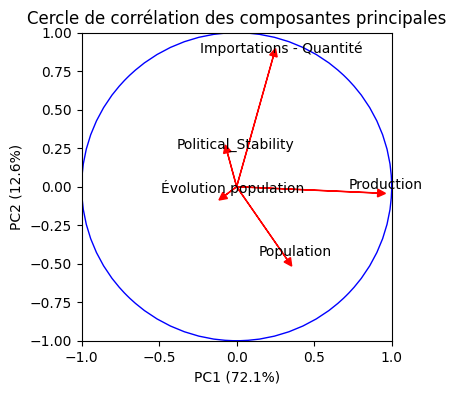

In [148]:
# Sélectionner uniquement les colonnes numériques pour l'ACP
numerical_data = data_normalized.drop('Pays', axis=1)

# Création de l'objet PCA
pca = PCA()

# Application de l'ACP sur les données numériques mises à jour
pca_data = pca.fit_transform(numerical_data)

# Création du cercle de corrélation
fig, ax = plt.subplots(figsize=(4, 4))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
ax.add_artist(circle)

# Afficher les flèches pour les composantes principales
for i, (comp1, comp2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    ax.arrow(0, 0, comp1, comp2, head_width=0.05, head_length=0.05, color='red')
    # Assurez-vous de compléter la ligne ci-dessous correctement
    plt.text(comp1 + 0.05, comp2 + 0.05, numerical_data.columns[i], color='black', ha='center', va='center')

# Limiter les axes pour une meilleure visibilité
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])

# Titres et labels
plt.xlabel('PC1 ({}%)'.format(round(100 * pca.explained_variance_ratio_[0], 1)))
plt.ylabel('PC2 ({}%)'.format(round(100 * pca.explained_variance_ratio_[1], 1)))
plt.title('Cercle de corrélation des composantes principales')

# Afficher le graphique
plt.show()


In [149]:
#1-Production et Poulation sont positivement corrélées avec PC1 et également entre elles.
#2-Importations - Quantité semble être négativement corrélée avec PC1.
#3-Political_Stability est proche de l'origine, ce qui suggère qu'elle ne contribue pas autant à la variance et n'est fortement corrélée ni avec PC1 ni avec PC2.
#4-Évolution population est modérément corrélée avec PC2.

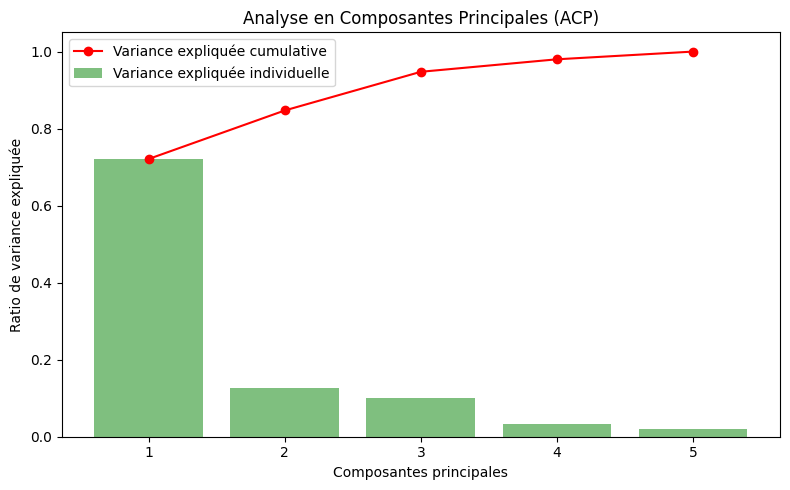

In [150]:
# Étape 2: Préparation des données pour l'ACP
# Vérifier la présence de valeurs manquantes et sélectionner uniquement les colonnes numériques
data_for_pca = data_normalized.drop(columns=['Pays'])
missing_values = data_for_pca.isnull().sum().sum()

# Étape 3: Réaliser l'ACP si aucune valeur manquante n'est détectée
if missing_values == 0:
    # Initialiser l'ACP
    pca = PCA()

    # Ajuster l'ACP sur les données
    pca.fit(data_for_pca)

    # Étape 4: Examiner les valeurs propres
    eigenvalues = pca.explained_variance_

    # Étape 5: Calculer la variance expliquée
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    # Préparer les résultats pour l'affichage
    pca_results = {
        'Eigenvalues': eigenvalues,
        'Explained Variance Ratio': explained_variance_ratio,
        'Cumulative Explained Variance': cumulative_explained_variance
    }

else:
    pca_results = "Il y a des valeurs manquantes dans les données, l'ACP ne peut pas être effectuée."

pca_results

import matplotlib.pyplot as plt

# Préparation des données pour le graphique
components = list(range(1, len(explained_variance_ratio) + 1))

# Création du graphique de la variance expliquée
plt.figure(figsize=(8, 5))

# Barres de la variance expliquée
plt.bar(components, explained_variance_ratio, alpha=0.5, align='center',
        label='Variance expliquée individuelle', color='g')

# Courbe de la variance expliquée cumulative
plt.plot(components, cumulative_explained_variance, label='Variance expliquée cumulative', marker='o', color='r')

# Titres et étiquettes
plt.ylabel('Ratio de variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Analyse en Composantes Principales (ACP)')
plt.xticks(components)
plt.legend(loc='best')
plt.tight_layout()

# Afficher le graphique
plt.show()





Text(0, 0.5, 'La distance euclidienne')

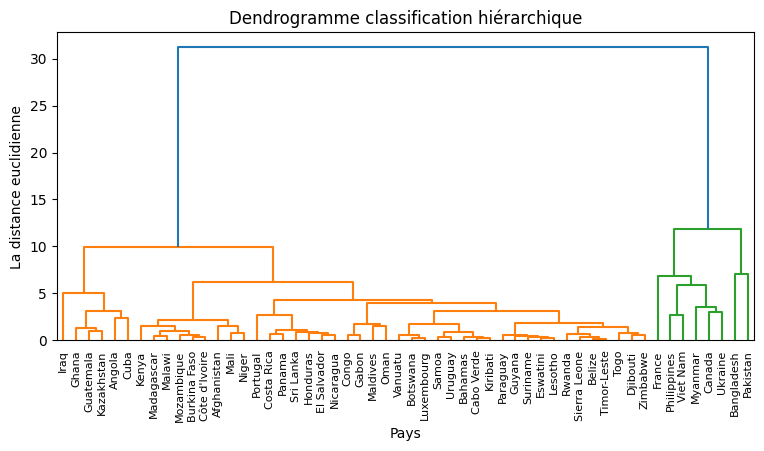

In [151]:
# Performing Hierarchical Clustering
Z = linkage(data_normalized[numeric_columns], method='ward')

# Plotting the dendrogram
plt.figure(figsize=(9, 4))
dendrogram(Z, labels=data_normalized['Pays'].values, leaf_rotation=90, leaf_font_size=8)
plt.title('Dendrogramme classification hiérarchique')
plt.xlabel('Pays')
plt.ylabel('La distance euclidienne')


In [152]:
# Définir la distance de coupure pour la détermination du nombre de clusters
# En observant le dendrogramme précédent, un bon point de coupure semble être aux alentours de 12
distance_cutoff = 12

# Obtenir les clusters en coupant le dendrogramme à la distance définie
clusters = fcluster(Z, distance_cutoff, criterion='distance')

# Ajouter les clusters assignés aux données originales pour une meilleure interprétation
data_normalized['Cluster'] = clusters

# Calculer le nombre de clusters formés
num_clusters = data_normalized['Cluster'].nunique()
num_clusters, data_normalized.groupby('Cluster')['Pays'].apply(list)

(2,
 Cluster
 1    [Afghanistan, Angola, Bahamas, Belize, Botswan...
 2    [Bangladesh, Canada, France, Myanmar, Pakistan...
 Name: Pays, dtype: object)

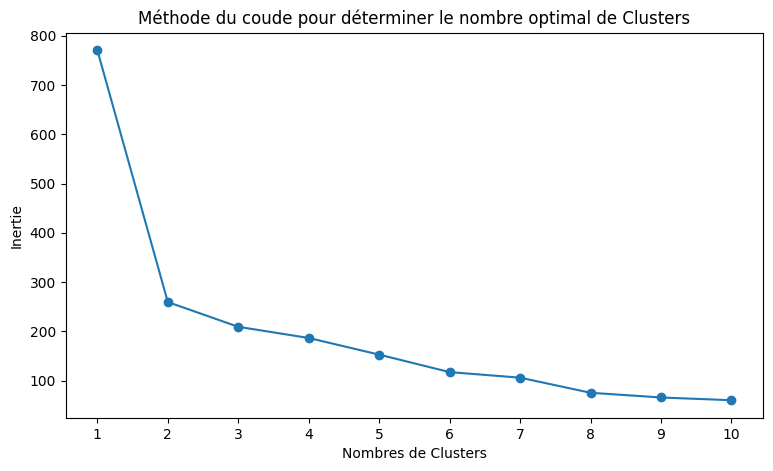

In [153]:
# Determining the optimal number of clusters using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_normalized[numeric_columns])
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(9, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Méthode du coude pour déterminer le nombre optimal de Clusters')
plt.xlabel('Nombres de Clusters')
plt.ylabel('Inertie')
plt.xticks(range(1, 11))
plt.show()


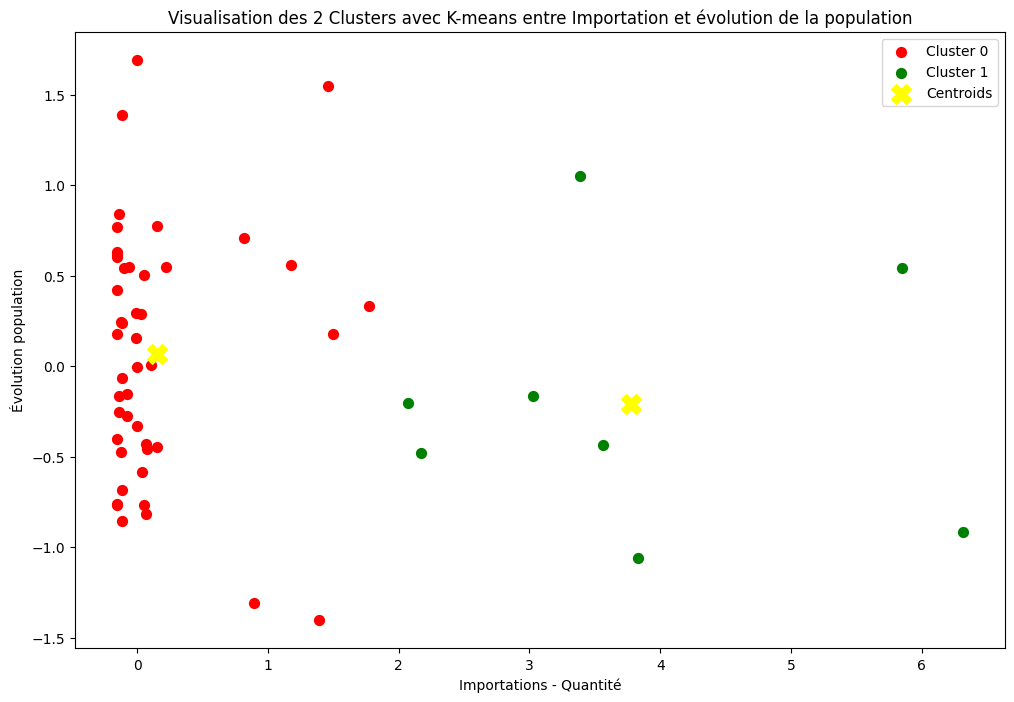

   Cluster  Importations - Quantité  Évolution population
0        0                 0.152799               0.06988
1        1                 3.777955              -0.20812


In [154]:
# Sélectionner uniquement les colonnes pour le clustering
columns_for_clustering = ['Importations - Quantité', 'Évolution population']
data_selected_for_clustering = data_normalized[columns_for_clustering]

# Définir une liste de couleurs pour les clusters
colors = ['red', 'green',]

# Appliquer l'algorithme des k-means avec 2 clusters sur les colonnes sélectionnées
kmeans_selected = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
cluster_labels_selected = kmeans_selected.fit_predict(data_selected_for_clustering)

# Ajouter les labels de cluster au dataframe original pour référence
data_normalized['Cluster (selected columns)'] = cluster_labels_selected

# Création du graphique
plt.figure(figsize=(12, 8))

# Tracer les points de données et les colorer en fonction de leur cluster
for cluster in range(2):
    clustered_data = data_normalized[data_normalized['Cluster (selected columns)'] == cluster]
    plt.scatter(clustered_data['Importations - Quantité'], clustered_data['Évolution population'],
                s=50, c=colors[cluster], label=f'Cluster {cluster}')

# Marquer les centroids
centroids_selected = kmeans_selected.cluster_centers_
plt.scatter(centroids_selected[:, 0], centroids_selected[:, 1], s=200, c='yellow', marker='X', label='Centroids')

plt.title('Visualisation des 2 Clusters avec K-means entre Importation et évolution de la population')
plt.xlabel('Importations - Quantité')
plt.ylabel('Évolution population')
plt.legend()
plt.show()

# Identifier les points avec des valeurs élevées en importation et en évolution de la population
# Nous pouvons définir un seuil pour ces valeurs
importation_threshold = data_normalized['Importations - Quantité'].quantile(0.75)  # 75th percentile
evolution_population_threshold = data_normalized['Évolution population'].quantile(0.75)  # 75th percentile

# Créer un DataFrame à partir des coordonnées des centroïdes
# Utiliser les mêmes noms de colonnes que ceux utilisés pour le clustering
centroids_df = pd.DataFrame(centroids_selected, columns=columns_for_clustering)
centroids_df.index.name = 'Cluster'
centroids_df.reset_index(inplace=True)

# Afficher le DataFrame
print(centroids_df)

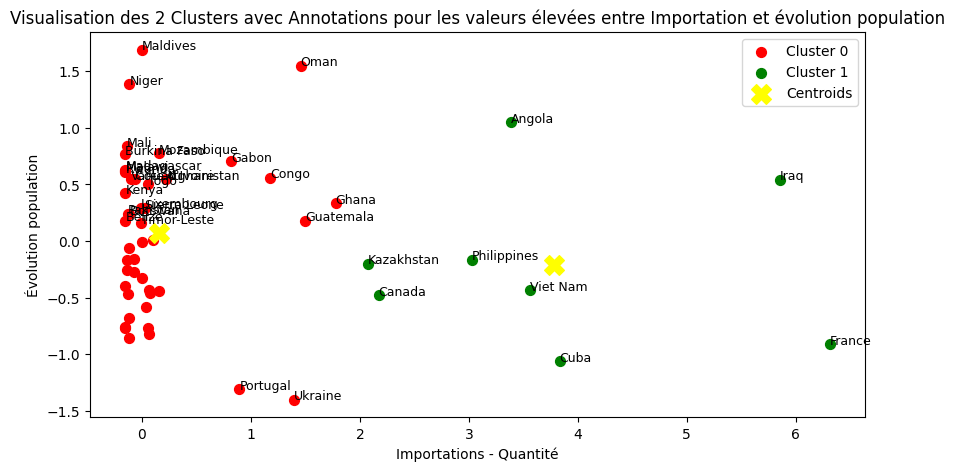

   Political_Stability  Importations - Quantité  Production  Population  \
0            -0.081765                 0.447284    0.147085    0.180927   
1            -0.525384                 2.318576    8.625381    2.978675   

   Évolution population  
0              0.114621  
1             -0.548239  


In [155]:
# Calculer la valeur moyenne pour la colonne 'Importations - Quantité'
importation_threshold_specific = data_normalized['Importations - Quantité'].mean()

# Calculer la valeur moyenne pour la colonne 'Évolution population'
evolution_population_threshold_specific = data_normalized['Évolution population'].mean()


# Création du graphique avec annotations
plt.figure(figsize=(10, 5))

for cluster in range(2):
    clustered_data = data_normalized[data_normalized['Cluster (selected columns)'] == cluster]
    plt.scatter(clustered_data['Importations - Quantité'], clustered_data['Évolution population'],
                s=50, c=colors[cluster], label=f'Cluster {cluster}')

# Annoter les points qui dépassent les seuils
for i, row in data_normalized.iterrows():
    if row['Importations - Quantité'] >= importation_threshold_specific or row['Évolution population'] >= evolution_population_threshold_specific:
        plt.text(row['Importations - Quantité'], row['Évolution population'], row['Pays'], fontsize=9)

# Marquer les centroids
plt.scatter(centroids_selected[:, 0], centroids_selected[:, 1], s=200, c='yellow', marker='X', label='Centroids')

plt.title('Visualisation des 2 Clusters avec Annotations pour les valeurs élevées entre Importation et évolution population')
plt.xlabel('Importations - Quantité')
plt.ylabel('Évolution population')
plt.legend()
plt.show()


# Ajustez le modèle KMeans avec les colonnes numériques restantes
kmeans.fit(data_normalized[numeric_columns])

# Exclure les colonnes de cluster de l'analyse
columns_to_exclude = ['Cluster', 'Cluster (selected columns)']
numeric_columns = [col for col in data_normalized.select_dtypes(include=[np.number]).columns if col not in columns_to_exclude]

# Ajustez le modèle K-Means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_normalized[numeric_columns])  # Utilisez les données, pas juste les noms des colonnes

# Extraire les centroïdes
centroids = kmeans.cluster_centers_

# Créer un DataFrame pour les centroïdes
centroids_df = pd.DataFrame(centroids, columns=numeric_columns)

# Afficher les centroïdes
print(centroids_df)

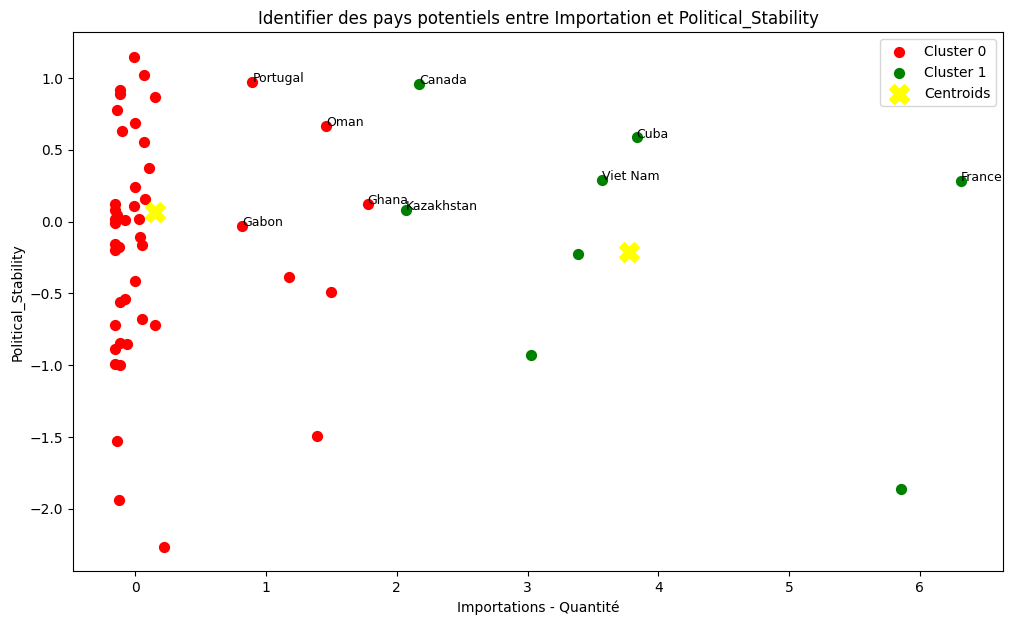

In [156]:
# Seuils spécifiques pour importation et évolution de la population
# Calculer la valeur moyenne pour la colonne 'Importations - Quantité'
importation_threshold_specific = data_normalized['Importations - Quantité'].mean()

# Calculer la valeur moyenne pour la colonne 'Évolution population'
political_Stability_threshold_specific = data_normalized['Political_Stability'].mean()

# Création du graphique avec annotations pour les valeurs spécifiques
plt.figure(figsize=(12, 7))

for cluster in range(2):
    clustered_data = data_normalized[data_normalized['Cluster (selected columns)'] == cluster]
    plt.scatter(clustered_data['Importations - Quantité'], clustered_data['Political_Stability'],
                s=50, c=colors[cluster], label=f'Cluster {cluster}')

# Annoter les points qui dépassent les seuils spécifiques
for i, row in data_normalized.iterrows():
    if row['Importations - Quantité'] > importation_threshold_specific and row['Political_Stability'] > political_Stability_threshold_specific:
        plt.text(row['Importations - Quantité'], row['Political_Stability'], row['Pays'], fontsize=9)

# Marquer les centroids
plt.scatter(centroids_selected[:, 0], centroids_selected[:, 1], s=200, c='yellow', marker='X', label='Centroids')

plt.title('Identifier des pays potentiels entre Importation et Political_Stability')
plt.xlabel('Importations - Quantité')
plt.ylabel('Political_Stability')
plt.legend()
plt.show()


In [157]:
# Ajustez le modèle KMeans avec les colonnes numériques restantes
kmeans.fit(data_normalized[numeric_columns])

# Exclure les colonnes de cluster de l'analyse
columns_to_exclude = ['Cluster', 'Cluster (selected columns)']
numeric_columns = [col for col in data_normalized.select_dtypes(include=[np.number]).columns if col not in columns_to_exclude]

# Ajustez le modèle K-Means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_normalized[numeric_columns])  # Utilisez les données, pas juste les noms des colonnes

# Extraire les centroïdes
centroids = kmeans.cluster_centers_

# Créer un DataFrame pour les centroïdes
centroids_df = pd.DataFrame(centroids, columns=numeric_columns)

# Afficher les centroïdes
print(centroids_df)

   Political_Stability  Importations - Quantité  Production  Population  \
0            -0.081765                 0.447284    0.147085    0.180927   
1            -0.525384                 2.318576    8.625381    2.978675   

   Évolution population  
0              0.114621  
1             -0.548239  


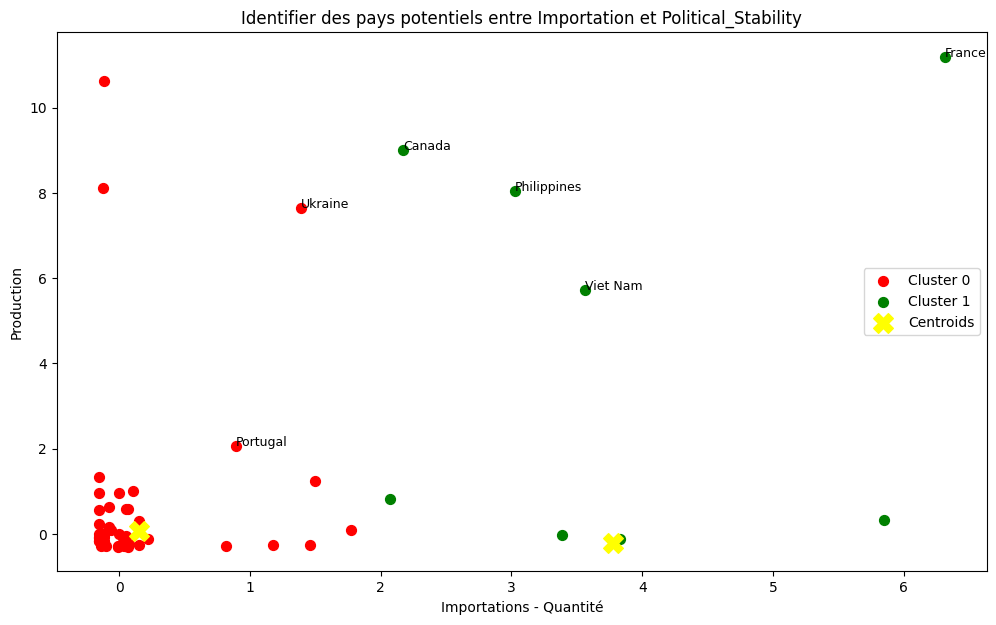

   Political_Stability  Importations - Quantité  Production  Population  \
0            -0.081765                 0.447284    0.147085    0.180927   
1            -0.525384                 2.318576    8.625381    2.978675   

   Évolution population  
0              0.114621  
1             -0.548239  


In [158]:
# Seuils spécifiques pour importation et évolution de la population
# Calculer la valeur moyenne pour la colonne 'Importations - Quantité'
importation_threshold_specific = data_normalized['Importations - Quantité'].mean()

# Calculer la valeur moyenne pour la colonne 'Évolution population'
political_Stability_threshold_specific = data_normalized['Production'].mean()

# Création du graphique avec annotations pour les valeurs spécifiques
plt.figure(figsize=(12, 7))

for cluster in range(2):
    clustered_data = data_normalized[data_normalized['Cluster (selected columns)'] == cluster]
    plt.scatter(clustered_data['Importations - Quantité'], clustered_data['Production'],
                s=50, c=colors[cluster], label=f'Cluster {cluster}')

# Annoter les points qui dépassent les seuils spécifiques
for i, row in data_normalized.iterrows():
    if row['Importations - Quantité'] > importation_threshold_specific and row['Production'] > political_Stability_threshold_specific:
        plt.text(row['Importations - Quantité'], row['Production'], row['Pays'], fontsize=9)

# Marquer les centroids
plt.scatter(centroids_selected[:, 0], centroids_selected[:, 1], s=200, c='yellow', marker='X', label='Centroids')

plt.title('Identifier des pays potentiels entre Importation et Political_Stability')
plt.xlabel('Importations - Quantité')
plt.ylabel('Production')
plt.legend()
plt.show()

# Ajustez le modèle KMeans avec les colonnes numériques restantes
kmeans.fit(data_normalized[numeric_columns])

# Exclure les colonnes de cluster de l'analyse
columns_to_exclude = ['Cluster', 'Cluster (selected columns)']
numeric_columns = [col for col in data_normalized.select_dtypes(include=[np.number]).columns if col not in columns_to_exclude]

# Ajustez le modèle K-Means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(data_normalized[numeric_columns])  # Utilisez les données, pas juste les noms des colonnes

# Extraire les centroïdes
centroids = kmeans.cluster_centers_

# Créer un DataFrame pour les centroïdes
centroids_df = pd.DataFrame(centroids, columns=numeric_columns)

# Afficher les centroïdes
print(centroids_df)

In [159]:
print("Les pays candidats idéaux sont suivants: France, Vietnam")

Les pays candidats idéaux sont suivants: France, Vietnam
